In [1]:
import pandas as pd
from utils import config

from sklearn.model_selection import train_test_split

config.xls_path = '../Train-Data/Mix6_mainCat_pipeline/pro_review.xlsx'
# config.xls_path = '/home/eagleuser/Users/leyan/Train-Data/Mix6_mainCat_new/pro_review.xlsx'
total_df = pd.read_excel(config.xls_path)
total_df['review_ID'] = total_df.review_ID.astype(str)

# total_df = total_df[total_df['review_len']>=50]
# total_df = total_df[total_df['summary_len']>=5]
total_df = total_df.sort_values(by=['review_len','overlap'], ascending = False)
train_df, val_df = train_test_split(total_df, test_size=0.1, 
                                    random_state=0, shuffle=True)

print(len(total_df))
print(len(train_df))
print(len(val_df))

# train : 504075(90%),    test : 56009(10%) -> best 566084

901434
811290
90144


In [2]:
def longest_common_subsequence(main_string, comparing_string):

#     main_string = main_string.split(" ")
#     comparing_string = comparing_string.split(" ")
    columns_length = len(main_string)  # Get the length of the first word or base word
    rows_length = len(comparing_string)  # Get the length of the second word or comparing word

    # MAKE A 2D LIST (MATRIX)
    dynamic_table = [[0] * (columns_length + 1) for i in range(rows_length + 1)]

    # rows_length = NUMBER OF ROWS
    # columns_length = NUMBER OF COLUMNS
    
    # FILL THE MATRIX FOLLOWING LCS ALGORITHM.
    for i in range(1, rows_length + 1):
        for j in range(1, columns_length + 1):
            if main_string[j - 1] == comparing_string[i - 1]:
                dynamic_table[i][j] = 1 + dynamic_table[i - 1][j - 1]

            else:
                dynamic_table[i][j] = max(dynamic_table[i - 1][j], dynamic_table[i][j - 1])

#     print("MATRIX ACCORDING TO LONGEST COMMON SUBSEQUENCE ALGORITHM: \n ")

    # for i in range(rows_length + 1):
    #     print(dynamic_table[i])

    #print("LENGTH OF LONGEST COMMON SUBSEQUENCE = ", dynamic_table[rows_length][columns_length])

    len_lcs = dynamic_table[rows_length][columns_length]

    i = len(comparing_string)
    j = len(main_string)

    lcs_string = str()

    # BACKTRACKING TO FIND THE LONGEST COMMON SUBSEQUENCE

    temp = True

    while temp is True:
        if dynamic_table[i][j] == 0:
            temp = False
        elif dynamic_table[i][j] == dynamic_table[i][j - 1]:
            j = j - 1

        else:
            lcs_string = main_string[j-1] + " " + lcs_string
            i = i - 1
            j = j - 1

    return lcs_string, len_lcs

In [3]:
# df.loc[i,'token_lcs'] = token_lcs
#             df.loc[i,'len_lcs'] = len_lcs
#             df.loc[i,'percent_lcs'] = percent_lcs
#             df.loc[i,'overlap_pos'] = overlap_pos
            
#             df.loc[i,'reveiw_len'] = len(rev_tokens)
#             df.loc[i,'summary_len'] = len(summary_tokens)

In [4]:
#%%
from tqdm import tqdm
from copy import deepcopy
def analay(df, mode):
    df['token_lcs'] = 0
    df['len_lcs'] = 0
    df['percent_lcs'] = 0
    df['overlap_pos'] = 0

    df['reveiw_len'] = 0
    df['summary_len'] = 0
#     df = df[:100]
    with tqdm(total=len(df)) as pbar:
        for i ,row in df.iterrows():       
            overlap_pos = None

            rev, summary = row['review'], row['summary']
            rev_tokens, summary_tokens = rev.split(" "), summary.split(" ")           
            token_lcs, len_lcs = longest_common_subsequence(rev_tokens, summary_tokens)
            percent_lcs = len_lcs / len(summary_tokens) * 100 # percent

            rev_sents = rev.split(" . ")
            overlap_sents = {idx: longest_common_subsequence(sent.split(" "), summary_tokens) for idx, sent in enumerate(rev_sents)}
            sort_overlap_sent = {k:v for k,v in sorted(overlap_sents.items(), key= lambda item: item[1], reverse=True)}
            overlap_sent_id = list(sort_overlap_sent.items())[0][0]

            if (overlap_sent_id == 0) and (percent_lcs >= 20): overlap_pos = 0 # overlap_Top 
            elif (overlap_sent_id == len(rev_tokens)-1) and (percent_lcs >= 20): overlap_pos = 1 # overlap_Final 
            elif (percent_lcs >= 20): overlap_pos = 2 # overlap_other 
            else: overlap_pos = -1 # no overlap 

            df.loc[i,'token_lcs'] = token_lcs
            df.loc[i,'len_lcs'] = len_lcs
            df.loc[i,'percent_lcs'] = percent_lcs
            df.loc[i,'overlap_pos'] = overlap_pos
            
            df.loc[i,'reveiw_len'] = len(rev_tokens)
            df.loc[i,'summary_len'] = len(summary_tokens)

            pbar.update(1)
            pbar.set_description("%s row: %s | overlap_pos: %s (%2.2f)percent| len_lcs: %s" % (mode, i, overlap_pos, percent_lcs, len_lcs))
#     df = df[df['token_lcs']!=0]
    return df



In [5]:
train_df.head()

,review_ID,rating,vote,binaryrating,review,summary,cheat,cheat_num,overlap,review_len,...,POS_keys,DEP_keys,Noun_adj_keys,TextRank_keys,len_lcs,percent_lcs,overlap_pos,token_lcs,summary_polarity,summary_subjectivity
499904,1488153600,3,2,negative,as other reviewer state this stuff work for a ...,<s> not a substitute for hot wax </s>,"{'a', 'wax', 'hot', 'for'}",4,4,74,...,"['', '', 'stick', 'snow', 'was', '']","['other', 'work', 'is', 'state']","['state', 'work', 'run', 'couple', 'stuff', 'r...","['reviewer', 'state']",3,37.500000,2,for wax wax,0.250000,0.850
117797,1258416000,1,18,negative,i purchase these drive because i was look for ...,<s> drive fail repeatedly quality does not mat...,"{'look', 'drive', 'fail'}",3,4,156,...,"['drive', 'grade', 'purchase', 'professional',...","['drive', 'purchase', 'grade', 'professional',...","['drive', 'grade', 'professional', 'drive', 'p...","['drive', 'grade', 'use', 'performance', 'perf...",3,30.000000,2,drive look not,-0.500000,0.300
153759,1385942400,5,2,positive,this is a great radar detector . i use escort ...,<s> great radar dectector worth the money </s>,"{'the', 'worth', 'radar', 'money', 'great'}",5,5,151,...,"['radar', 'detector', 'great', '', '', 'great'...","['detector', 'great', 'use', 'escort', '8500x5...","['radar', 'great', '8500x50', 'escort', 'year'...","['great', 'speed', 'ticket', 'buy', 'protection']",5,62.500000,2,great radar the the money,0.550000,0.425
316710,1227052800,4,2,positive,the mouse is precise and has a fast response ....,<s> cheap fast precise but bulky mouse and sli...,"{'but', 'dock', 'and', 'bulky', 'precise', 'fa...",7,7,97,...,"['fast', 'response', 'precise', 'mouse', 'batt...","['response', 'is', 'precise', 'fast', 'mouse',...","['response', 'mouse', 'precise', 'fast', 'shap...","['price', 'fast']",4,36.363636,2,mouse and and dock,0.333333,0.700
850679,1379030400,5,3,positive,for year i suffer with shear to remove the mat...,<s> great for small dog and cat </s>,"{'dog', 'and', 'for', 'cat'}",4,4,89,...,"['remove', 'matting', 'tool', 'special', 'were...","['remove', 'matting', 'tool', 'special', 'sort...","['tool', 'special', 'tool', 'need', 'work', 'd...","['help', 'remove']",3,37.500000,0,for cat and,0.275000,0.575


In [6]:
val_df.head()

,review_ID,rating,vote,binaryrating,review,summary,cheat,cheat_num,overlap,review_len,...,POS_keys,DEP_keys,Noun_adj_keys,TextRank_keys,len_lcs,percent_lcs,overlap_pos,token_lcs,summary_polarity,summary_subjectivity
249123,1427760000,3,10,negative,the taotronic may be one of the most aesthetic...,<s> very portable but has substantial issue </s>,"{'but', 'portable', 'substantial', 'very', 'has'}",5,5,553,...,"['', 'extendable', 'steel', 'manual', 'stainle...","['feature', 'taotronic', 'be', 'has', 'test', ...","['stick', 'taotronic', 'selfie', 'own', 'test'...","['phone', 'phones', 'selfie', 'stick', 'app', ...",4,50.000000,2,but has substantial substantial,0.200000,0.3000
488278,1419811200,5,11,positive,easy to assemble 20 min even though there were...,<s> we experience almost immediate result this...,"{'this', 'is', 'great', 'we'}",4,4,164,...,"['', 'new', 'wife', 'restless', 'leg', 'syndro...","['min', 'assemble', 'new', 'use', 'attack', 'h...","['week', 'wife', 'night', 'leg', 'energy', 'ne...","['min', 'assemble', 'start', 'use', 'leg']",3,27.272727,2,we is great,0.800000,0.7500
811533,1363737600,3,15,negative,so i purchase this because it look ultra cute ...,<s> i like it but not worth the price </s>,"{'it', 'i', 'the', 'but'}",4,5,111,...,"['new', 'doggie', '', '', 'padded', 'siding', ...","['new', 'purchase', 'plush', 'doggie', 'cute',...","['doggie', 'new', 'mat', 'wash', 'happy', 'bit...","['look', 'ultra', 'cute']",5,50.000000,2,i it but the the,-0.150000,0.1000
831748,1330473600,3,6,negative,i find this pad to fit okay in the top tray of...,<s> fit but it is not the same pad as come wit...,"{'it', 'the', 'but', 'pad', 'fit', 'is', 'come...",8,11,84,...,"['pad', 'top', 'tray', 'find', '', '', '', '',...","['top', 'find', 'pad', 'fit', 'tray', 'fluval'...","['pad', 'tray', 'top', 'pad', 'same', 'pad', '...","['fit', 'okay']",12,80.000000,2,fit but it is not the same pad come with the 206,0.200000,0.2625
611599,1529798400,1,2,negative,as everyone else mention these filter clog inc...,<s> as everyone else mention these filter clog...,"{'incredibly', 'everyone', 'as', 'clog', 'else...",7,9,62,...,"['filter', 'clog', 'drip', 'slow', 'rate', '',...","['everyone', 'mention', 'clog', 'slow', 'rate']","['clog', 'filter', 'total', 'use', 'day', 'dri...","['filter', 'clog']",9,81.818182,2,as everyone else mention these filter clog inc...,0.333333,0.5000


In [7]:
import os

if os.path.exists('Analay/train_pipeline_df.xlsx'):
    print('True')
    p_train_df = pd.read_excel('Analay/train_pipeline_df.xlsx')
    p_val_df = pd.read_excel('Analay/val_pipeline_df.xlsx')
else:    
    p_train_df = analay(deepcopy(train_df), 'train')
    p_train_df.to_excel('Analay/train_pipeline_df.xlsx', encoding='utf8')

    p_val_df = analay(deepcopy(val_df), 'test')
    p_val_df.to_excel('Analay/val_pipeline_df.xlsx', encoding='utf8')

True


In [8]:
p_train_df['review_ID'] = p_train_df.review_ID.astype(str)
p_train_df.describe()

,rating,vote,cheat_num,overlap,review_len,summary_len,len_lcs,percent_lcs,overlap_pos,summary_polarity,summary_subjectivity,reveiw_len
count,811290.000000,811290.000000,811290.000000,811290.000000,811290.000000,811290.000000,811290.000000,811290.000000,811290.000000,811290.000000,811290.000000,811290.000000
mean,3.641745,10.804366,6.366933,7.117907,191.736918,11.478404,6.511284,54.568720,1.557925,0.265480,0.492240,191.736918
std,1.524361,39.063616,3.165013,3.575878,154.760094,3.709440,4.066999,20.504786,0.848886,0.382833,0.316340,154.760094
min,1.000000,2.000000,3.000000,3.000000,24.000000,6.000000,1.000000,4.347826,-1.000000,-1.000000,0.000000,24.000000
25%,2.000000,2.000000,4.000000,5.000000,88.000000,9.000000,4.000000,37.500000,2.000000,0.000000,0.275000,88.000000
50%,4.000000,4.000000,6.000000,6.000000,139.000000,11.000000,5.000000,50.000000,2.000000,0.250000,0.541667,139.000000
75%,5.000000,8.000000,8.000000,9.000000,236.000000,13.000000,8.000000,75.000000,2.000000,0.500000,0.750000,236.000000
max,5.000000,4971.000000,43.000000,50.000000,1000.000000,65.000000,63.000000,96.923077,2.000000,1.000000,1.000000,1000.000000


In [9]:
import matplotlib.pyplot as plt

hist = p_train_df['reveiw_len'].hist(bins=10)
s = p_train_df['reveiw_len'].describe(); print(s)
print('reveiw_len < 30 :',len(p_train_df[p_train_df['reveiw_len']<30]))
print('reveiw_len > 500 :',len(p_train_df[p_train_df['reveiw_len']>=500])) # # max pos, max_enc_steps 
plt.ylabel('length')
plt.title('reveiw_len')

count    811290.000000
mean        191.736918
std         154.760094
min          24.000000
25%          88.000000
50%         139.000000
75%         236.000000
max        1000.000000
Name: reveiw_len, dtype: float64
reveiw_len < 30 : 5
reveiw_len > 500 : 45245


Text(0.5, 1.0, 'reveiw_len')

summary_len > 30 : 527
summary_len <= 5 : 0
count    811290.000000
mean         11.478404
std           3.709440
min           6.000000
25%           9.000000
50%          11.000000
75%          13.000000
max          65.000000
Name: summary_len, dtype: float64


Text(0.5, 1.0, 'summary_len')

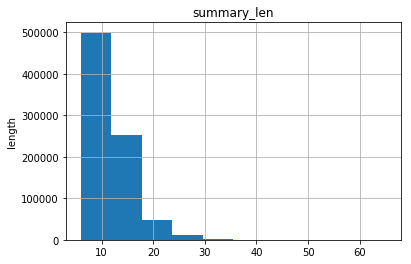

In [10]:
print('summary_len > 30 :',len(p_train_df[p_train_df['summary_len']>30]))  # max_dec_steps
print('summary_len <= 5 :',len(p_train_df[p_train_df['summary_len']<6])) # min_dec_steps
hist = p_train_df['summary_len'].hist(bins=10)
s = p_train_df['summary_len'].describe(); print(s)
plt.ylabel('length')
plt.title('summary_len')

# Rating

Text(0.5, 1.0, 'Rating')

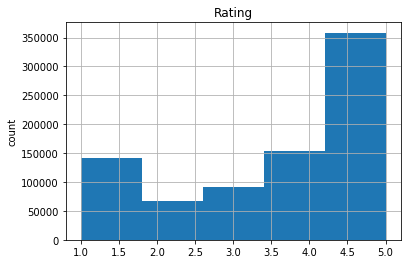

In [13]:
hist = p_train_df['rating'].hist(bins=5)
# s = p_train_df['vote'].describe(); print(s)
plt.ylabel('count')
plt.title('Rating')

# sentiment

summary_polarity and summary_subjectivity  > 0 : 543444
count    811290.000000
mean          0.492240
std           0.316340
min           0.000000
25%           0.275000
50%           0.541667
75%           0.750000
max           1.000000
Name: summary_subjectivity, dtype: float64


Text(0.5, 1.0, 'summary_subjectivity')

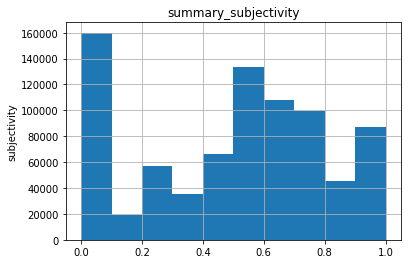

In [14]:
print('summary_polarity and summary_subjectivity  > 0 :',len(p_train_df[
    (abs(p_train_df['summary_polarity'])>0.1) &
    (p_train_df['summary_subjectivity']>0.25)

]))  # max_dec_steps
# print('summary_len <= 5 :',len(p_train_df[p_train_df['summary_len']<6])) # min_dec_steps

hist = p_train_df['summary_subjectivity'].hist(bins=10)
s = p_train_df['summary_subjectivity'].describe(); print(s)
plt.ylabel('subjectivity')
plt.title('summary_subjectivity')

summary_polarity and summary_subjectivity  > 0 : 543444
count    811290.000000
mean          0.265480
std           0.382833
min          -1.000000
25%           0.000000
50%           0.250000
75%           0.500000
max           1.000000
Name: summary_polarity, dtype: float64


Text(0.5, 1.0, 'summary_polarity')

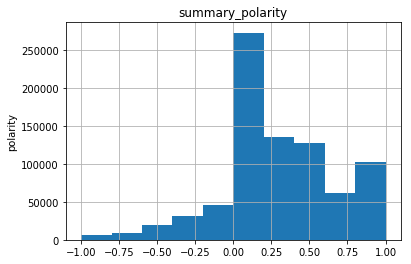

In [15]:
print('summary_polarity and summary_subjectivity  > 0 :',len(p_train_df[
    (abs(p_train_df['summary_polarity'])>0.1) &
    (p_train_df['summary_subjectivity']>0.25)

]))  # max_dec_steps
# print('summary_len <= 5 :',len(p_train_df[p_train_df['summary_len']<6])) # min_dec_steps

hist = p_train_df['summary_polarity'].hist(bins=10)
s = p_train_df['summary_polarity'].describe(); print(s)
plt.ylabel('polarity')
plt.title('summary_polarity')

# Prune data length

In [16]:
print('reveiw_len <= 500 and summary_len<= 20:',len(p_train_df[
    (p_train_df['reveiw_len']<=500) & (p_train_df['summary_len']<=20) &
    (abs(p_train_df['summary_polarity'])>0.1) &
    (p_train_df['summary_subjectivity']>0.25)    
                                        ]))

min_df = p_train_df[
    (p_train_df['reveiw_len']<=500) & (p_train_df['summary_len']<=20) &
    (abs(p_train_df['summary_polarity'])>0.1) &
    (p_train_df['summary_subjectivity']>0.25)    
                                        ]

# print('reveiw_len > 7000 :',len(p_train_df[p_train_df['reveiw_len']>=700])) # # max pos, max_enc_steps 
# s = p_train_df['reveiw_len'].describe(); print(s)
# s = s.drop(labels = ['count'])
# s.plot.bar()
# plt.ylabel('length')
# plt.title('reveiw_len')
# plt.show()

reveiw_len <= 500 and summary_len<= 20: 494635


# percent_lcs EDA(20 divided)

count    494635.000000
mean         54.642645
std          20.875017
min           5.882353
25%          37.500000
50%          50.000000
75%          75.000000
max          90.000000
Name: percent_lcs, dtype: float64


Text(0.5, 1.0, 'percent_lcs')

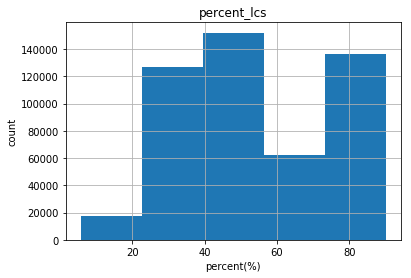

In [31]:
hist = min_df['percent_lcs'].hist(bins=5)
s = min_df['percent_lcs'].describe(); print(s)
plt.ylabel('count')
plt.xlabel('percent(%)')
plt.title('percent_lcs')

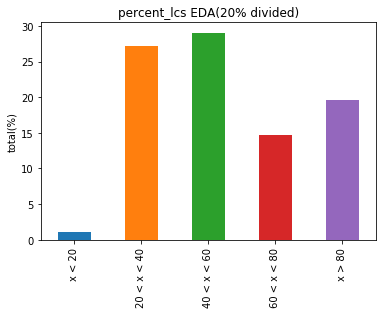

In [32]:
# 统计学上的四分为函数
# 原则上p是可以取0到1之间的任意值的。但是有一个四分位数是p分位数中较为有名的。

# 所谓四分位数；即把数值由小到大排列并分成四等份，处于三个分割点位置的数值就是四分位数。

# 第1四分位数 (Q1)，又称“较小四分位数”，等于该样本中所有数值由小到大排列后第25%的数字。
# 第2四分位数 (Q2)，又称“中位数”，等于该样本中所有数值由小到大排列后第50%的数字。
# 第3四分位数 (Q3)，又称“较大四分位数”，等于该样本中所有数值由小到大排列后第75%的数字。
# 第3四分位数与第1四分位数的差距又称四分位距（InterQuartile Range,IQR）

s = pd.Series({'x < 20':len(min_df[min_df['percent_lcs']<20])/len(min_df)*100, 
           '20 < x < 40':len(min_df[(min_df['percent_lcs']>20) & (min_df['percent_lcs']<40)])/len(min_df)*100, 
           '40 < x < 60':len(min_df[(min_df['percent_lcs']>40) & (min_df['percent_lcs']<60)])/len(min_df)*100, 
           '60 < x < 80':len(min_df[(min_df['percent_lcs']>60) & (min_df['percent_lcs']<80)])/len(min_df)*100, 
           'x > 80':len(min_df[min_df['percent_lcs']>80])/len(min_df)*100          
          })
s.plot.bar()
plt.ylabel('total(%)')
plt.title('percent_lcs EDA(20% divided)')
plt.show()

overlap Top :10.87 %
overlap Final :0.00 %
overlap Other Pos :35.14 %
No overlap :53.99 %


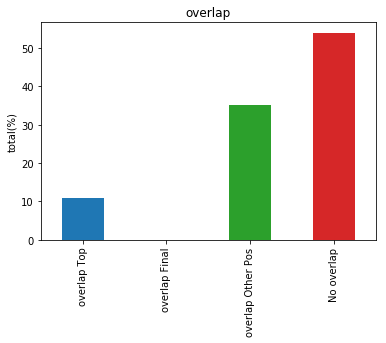

In [34]:
'''
overlap => percent_lcs > (50% summary len)
overlap_pos : 0 Top
overlap_pos : 1 Final
overlap_pos : 2 Other Pos
overlap_pos : -1 No overlap
'''

print('overlap Top :%2.2f'% float(len(min_df[(min_df['overlap_pos'] == 0) & (min_df['percent_lcs']>50)])/len(min_df)*100),'%') 
print('overlap Final :%2.2f'% float(len(min_df[(min_df['overlap_pos'] == 1) & (min_df['percent_lcs']>50)])/len(min_df)*100),'%') 
print('overlap Other Pos :%2.2f'% float(len(min_df[(min_df['overlap_pos'] == 2) & (min_df['percent_lcs']>50)])/len(min_df)*100),'%') 
print('No overlap :%2.2f'% float(len(min_df[(min_df['percent_lcs']<=50)])/len(min_df)*100),'%') 

s = pd.Series({'overlap Top':len(min_df[(min_df['overlap_pos'] == 0) & (min_df['percent_lcs']>50)])/len(min_df)*100, 
           'overlap Final':len(min_df[(min_df['overlap_pos'] == 1) & (min_df['percent_lcs']>50)])/len(min_df)*100,      
           'overlap Other Pos':len(min_df[(min_df['overlap_pos'] == 2) & (min_df['percent_lcs']>50)])/len(min_df)*100,  
           'No overlap':len(min_df[(min_df['percent_lcs']<=50)])/len(min_df)*100,  
          })
s.plot.bar()
plt.ylabel('total(%)')
plt.title('overlap')
plt.show()

# Ext/Abs分界(50)

percent_lcs x > 50  46.01 %
percent_lcs x <= 50  53.99 %


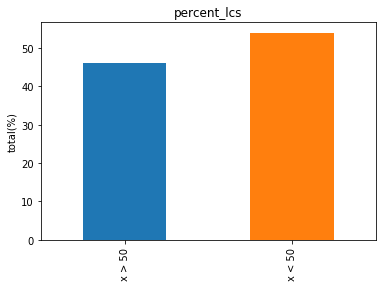

In [35]:
print('percent_lcs x > 50  %2.2f'% float(len(min_df[(min_df['percent_lcs']>50)])/len(min_df)*100),'%')  # max_dec_steps
print('percent_lcs x <= 50  %2.2f'% float(len(min_df[(min_df['percent_lcs']<=50)])/len(min_df)*100),'%')  # max_dec_steps

s = pd.Series({'x > 50':len(min_df[(min_df['percent_lcs']>50)])/len(min_df)*100, 
           'x < 50':len(min_df[(min_df['percent_lcs']<=50)])/len(min_df)*100,      
          })
s.plot.bar()
plt.ylabel('total(%)')
plt.title('percent_lcs')
plt.show()

overlap Top :10.87 %
overlap Final :0.00 %
overlap Other Pos :35.14 %
No overlap :53.99 %


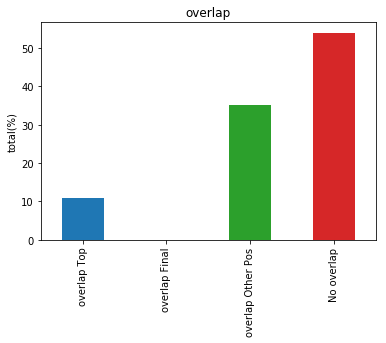

In [36]:
'''
overlap => percent_lcs > (50% summary len)
overlap_pos : 0 Top
overlap_pos : 1 Final
overlap_pos : 2 Other Pos
overlap_pos : -1 No overlap
'''

print('overlap Top :%2.2f'% float(len(min_df[(min_df['overlap_pos'] == 0) & (min_df['percent_lcs']>50)])/len(min_df)*100),'%') 
print('overlap Final :%2.2f'% float(len(min_df[(min_df['overlap_pos'] == 1) & (min_df['percent_lcs']>50)])/len(min_df)*100),'%') 
print('overlap Other Pos :%2.2f'% float(len(min_df[(min_df['overlap_pos'] == 2) & (min_df['percent_lcs']>50)])/len(min_df)*100),'%') 
print('No overlap :%2.2f'% float(len(min_df[(min_df['percent_lcs']<=50)])/len(min_df)*100),'%') 

s = pd.Series({'overlap Top':len(min_df[(min_df['overlap_pos'] == 0) & (min_df['percent_lcs']>50)])/len(min_df)*100, 
           'overlap Final':len(min_df[(min_df['overlap_pos'] == 1) & (min_df['percent_lcs']>50)])/len(min_df)*100,      
           'overlap Other Pos':len(min_df[(min_df['overlap_pos'] == 2) & (min_df['percent_lcs']>50)])/len(min_df)*100,  
           'No overlap':len(min_df[(min_df['percent_lcs']<=50)])/len(min_df)*100,  
          })
s.plot.bar()
plt.ylabel('total(%)')
plt.title('overlap')
plt.show()

In [38]:
def view(df, condition, view_num=10):
    package_dict = []
    for i in range(view_num):
        d1 = dict(min_df[eval(condition)].iloc[i])
        d2 = {'review':d1['review'],
              'summary':d1['summary'],
              'token_lcs':d1['token_lcs'],
              'overlap':d1['overlap'],
              'percent_lcs':d1['percent_lcs'],
              'keywords':d1['POS_keys']            
             }
        package_dict.append(d2)
    return package_dict
        
# view(min_df, "(min_df['overlap_pos'] == 2) & (min_df['percent_lcs']<50)")
view(min_df, "(min_df['review_len']<=50) & (min_df['percent_lcs']<=40) & (min_df['summary_len']>=15)")

[{'review': 'the knife from the set i get is completely dull with no serration remain . in fact it is not even part of the set each piece has a serial number it is much more used pretty much useless . otherwise it is a nice set and great size .',
  'summary': '<s> knife is totally dull could cut a piece of cheese cake i suppose </s>',
  'token_lcs': 'knife i dull of ',
  'overlap': 7,
  'percent_lcs': 26.66666666666667,
  'keywords': "['serration', 'dull', 'much', 'used', 'serial', 'number', 'set', 'great', 'nice', 'size']"},
 {'review': 'i love this hoodie so much that i buy in several color . it is make of soft material and the fit is as expect and true to size . when i wash it i lay it out to dry so i do not know of any shrinkage .',
  'summary': '<s> soft hoodie warm hoodie warm and cottony happy wearer sleepy wearer purr purr purr </s>',
  'token_lcs': 'hoodie and ',
  'overlap': 3,
  'percent_lcs': 12.5,
  'keywords': "['several', 'hoodie', 'color', 'love', 'material', 'soft', ''

In [39]:
dict(min_df[(min_df['overlap_pos'] == 2) & (min_df['percent_lcs']>50)].iloc[0:10])['summary']

153759       <s> great radar dectector worth the money </s>
450402    <s> great freedive snorkel replace the clip if...
636439    <s> if your car does not have bluetooth this i...
367298    <s> it wash fine it does what it is suppose to...
253468    <s> an absolute must for higher end headphone ...
658137    <s> for a cheap holster this thing is great fr...
338602    <s> i highly recommend it to anyone who want a...
230505     <s> glad i get this and will use it all the </s>
262202    <s> for the price the q800 is an excellent val...
29112               <s> good binocular at a good price </s>
Name: summary, dtype: object